In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

In [2]:
em = sc.read('K135_lusc_Epi.h5ad')
em

AnnData object with n_obs × n_vars = 46650 × 4000
    obs: 'Tissue', 'Disease', 'Stage', 'CellName', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', 'sample', 'patient', 'cell type', 'cnv_leiden', 'cnv_score', 'cnv_status', 'stage_group', 'stage_sample', 'leiden_1', 'subtype'
    var: 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell type_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'cnv_status_colors', 'dendrogram_leiden_0.8', 'dendrogram_leiden_1', 'hvg', 'leiden', 'leiden_0.8_colors', 'leiden_1_colors', 'neighbors', 'pca', 'sample_colors', 'source_colors', 'subtype_colors', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities', 'distances'

In [5]:
em = em.raw.to_adata()
em.raw = em
em

AnnData object with n_obs × n_vars = 46650 × 17039
    obs: 'Tissue', 'Disease', 'Stage', 'CellName', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source', 'sample', 'patient', 'cell type', 'cnv_leiden', 'cnv_score', 'cnv_status', 'stage_group', 'stage_sample', 'leiden_1', 'subtype'
    var: 'mt'
    uns: 'cell type_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'cnv_status_colors', 'dendrogram_leiden_0.8', 'dendrogram_leiden_1', 'hvg', 'leiden', 'leiden_0.8_colors', 'leiden_1_colors', 'neighbors', 'pca', 'sample_colors', 'source_colors', 'subtype_colors', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_pca', 'X_pca_harmony', 'X_umap'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities', 'distances'

In [4]:
em.obs.drop(['leiden_0.8','leiden_1'], axis=1, inplace=True)
em.obs

KeyError: "['leiden_0.8'] not found in axis"

# Epithelial cell annotation

In [5]:
# extract top highly variable genes
sc.pp.highly_variable_genes(em, flavor='seurat', n_top_genes=4000, span=0.3, n_bins=20, min_mean=0.0125, max_mean=3, min_disp=0.5)
# actually do the filtering
em = em[:, em.var.highly_variable]
# regress out effects of total counts per cell, percentages of mitochondrial gene counts and heat shock protein (HSP) related gene counts 
sc.pp.regress_out(em, ['total_counts', 'pct_counts_mt'])
# scale data
sc.pp.scale(em, max_value=10)
# run dimensionality reduction
sc.pp.pca(em, svd_solver='arpack', n_comps=50)

In [6]:
# perform Harmony using PCA results to adjust the PCs
sc.external.pp.harmony_integrate(em, 'sample', basis='X_pca', adjusted_basis='X_pca_harmony', max_iter_harmony = 100)

2023-07-04 14:33:51,683 - harmonypy - INFO - Iteration 1 of 100
2023-07-04 14:34:20,319 - harmonypy - INFO - Iteration 2 of 100
2023-07-04 14:34:49,290 - harmonypy - INFO - Iteration 3 of 100
2023-07-04 14:35:19,399 - harmonypy - INFO - Iteration 4 of 100
2023-07-04 14:35:51,308 - harmonypy - INFO - Iteration 5 of 100
2023-07-04 14:36:21,644 - harmonypy - INFO - Iteration 6 of 100
2023-07-04 14:36:53,713 - harmonypy - INFO - Iteration 7 of 100
2023-07-04 14:37:18,976 - harmonypy - INFO - Iteration 8 of 100
2023-07-04 14:37:41,050 - harmonypy - INFO - Iteration 9 of 100
2023-07-04 14:38:11,558 - harmonypy - INFO - Iteration 10 of 100
2023-07-04 14:38:31,661 - harmonypy - INFO - Iteration 11 of 100
2023-07-04 14:38:54,450 - harmonypy - INFO - Iteration 12 of 100
2023-07-04 14:39:12,354 - harmonypy - INFO - Iteration 13 of 100
2023-07-04 14:39:30,831 - harmonypy - INFO - Iteration 14 of 100
2023-07-04 14:39:52,336 - harmonypy - INFO - Iteration 15 of 100
2023-07-04 14:40:08,992 - harmonyp

In [7]:
# perform BBKNN using Harmony results
sc.external.pp.bbknn(em, batch_key='sample', use_rep='X_pca_harmony', n_pcs=50)

/data/hour/miniconda3/lib/python3.8/site-packages/numba/core/cpu.py:97: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.22.4 (/data/hour/miniconda3/lib/python3.8/site-packages), Requirement.parse('numpy<1.22,>=1.18'), {'numba'}))'.
  numba.core.entrypoints.init_all()
2023-07-04 14:44:38.339000: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-04 14:44:38.339335: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/data/hour/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/hour/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


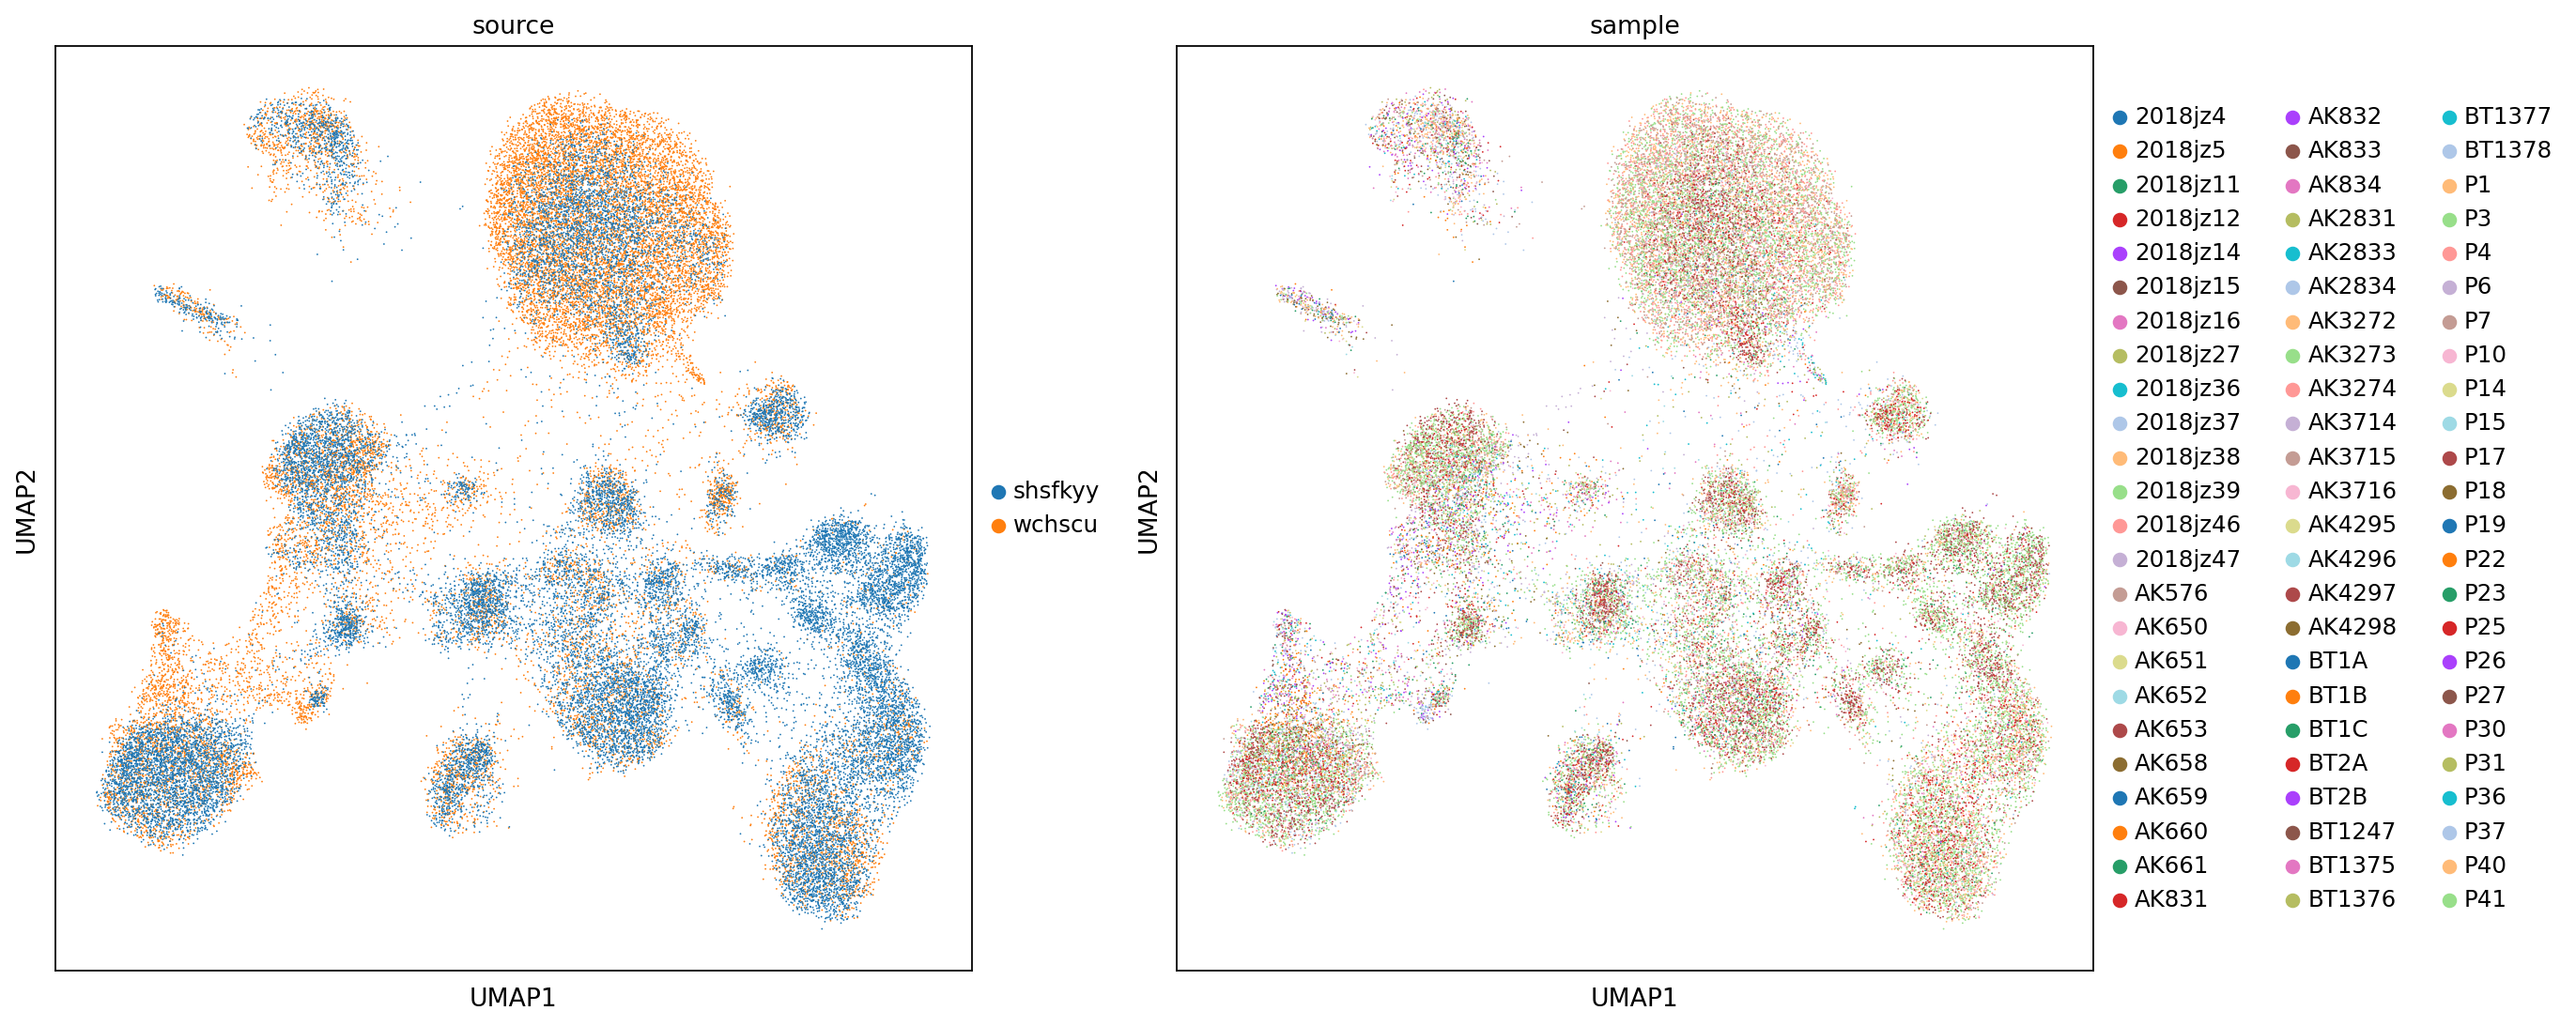

In [8]:
sc.settings.set_figure_params(fontsize=12, figsize=(8,8))
# obtain UMAP plot
sc.tl.umap(em)
sc.pl.umap(em, color=['source','sample'], ncols=2, palette=sc.pl.palettes.vega_20_scanpy)

/data/hour/miniconda3/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/data/hour/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


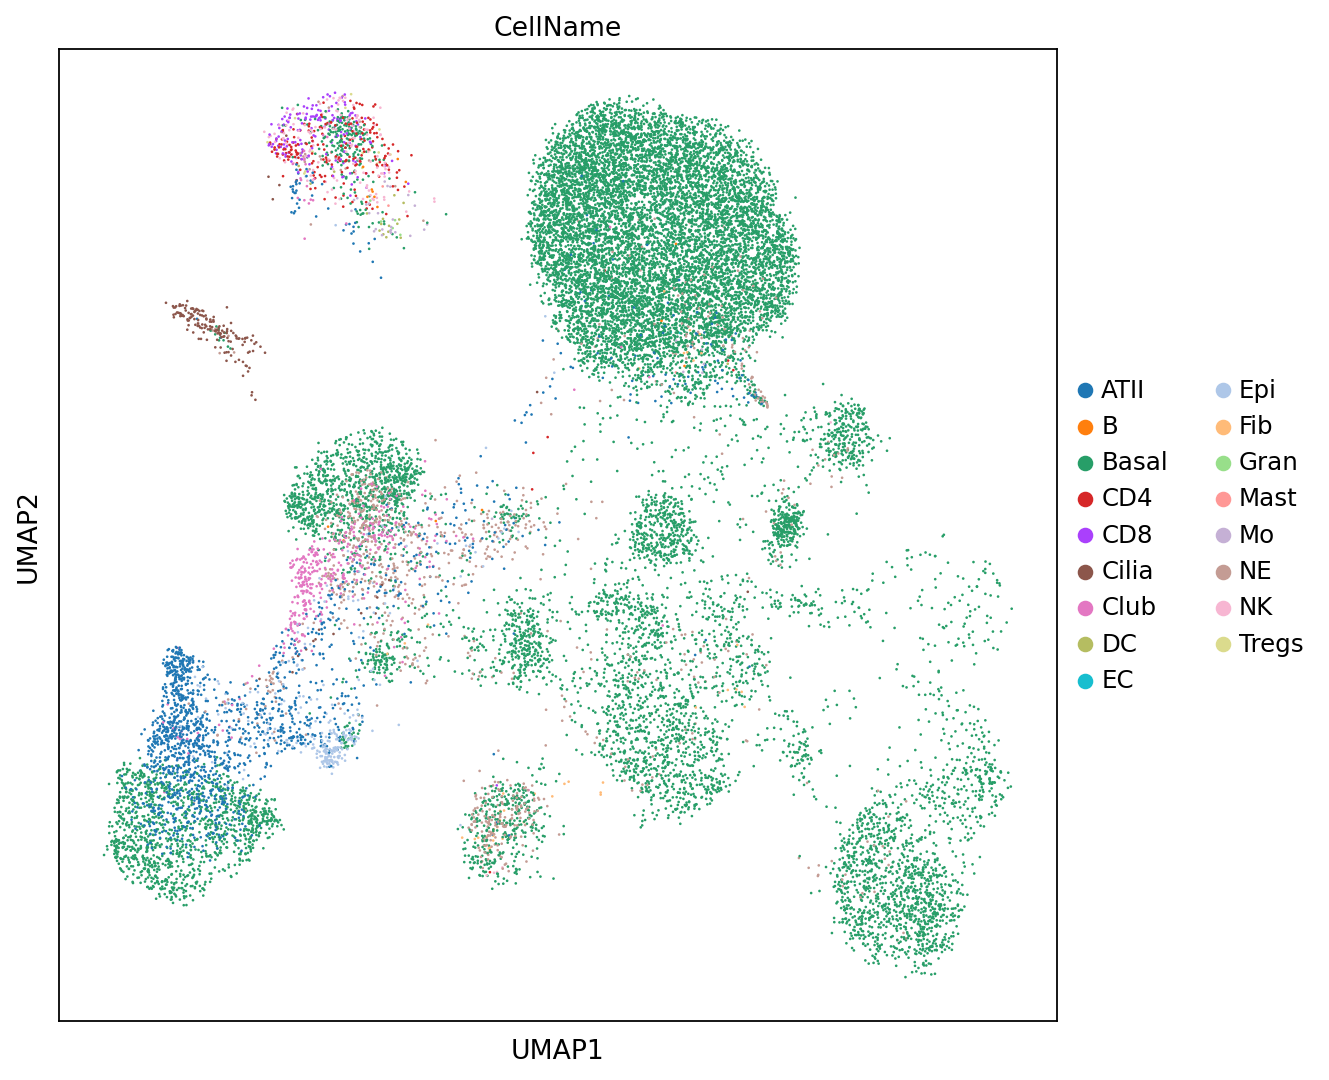

In [9]:
sc.pl.umap(em[em.obs['source']=='wchscu'], color='CellName', ncols=2, palette=sc.pl.palettes.vega_20_scanpy)

In [ ]:
# leiden clustering
sc.tl.leiden(em, resolution=0.8, random_state=0, key_added='leiden_0.8')# check the clusters on the UMAP
sc.tl.dendrogram(em,groupby='leiden_0.8')
sc.pl.umap(em,color=['leiden_0.8'],legend_loc='on data',palette=sc.pl.palettes.vega_20_scanpy)

In [ ]:
# leiden clustering
sc.tl.leiden(em, resolution=1.2, random_state=0, key_added='leiden_1.2')# check the clusters on the UMAP
sc.pl.umap(em,color=['leiden_1.2'],legend_loc='on data',palette=sc.pl.palettes.vega_20_scanpy)

/data/hour/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


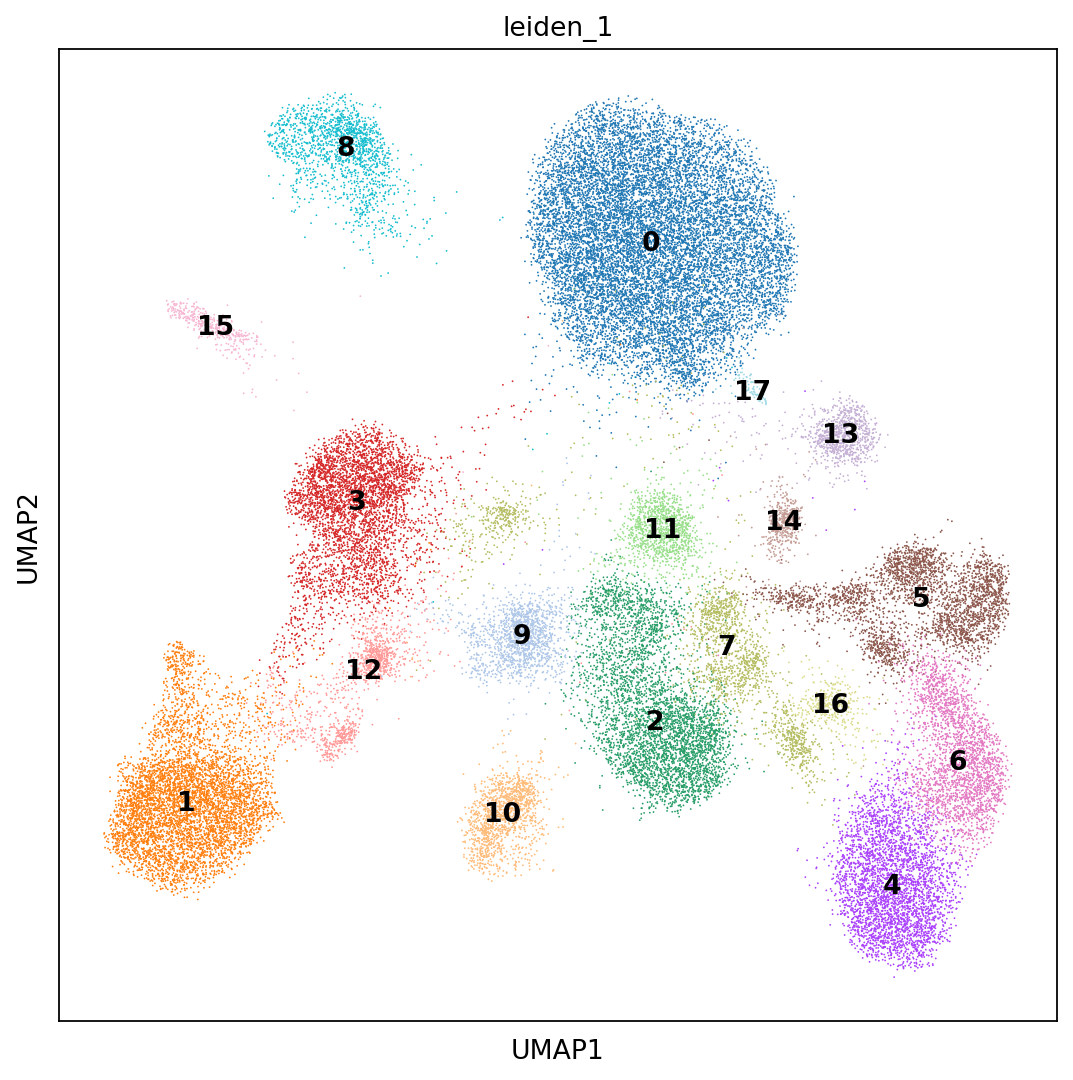

In [10]:
# leiden clustering
sc.tl.leiden(em, resolution=1, random_state=0, key_added='leiden_1')# check the clusters on the UMAP
sc.tl.dendrogram(em,groupby='leiden_1')
sc.pl.umap(em,color=['leiden_1'],legend_loc='on data',palette=sc.pl.palettes.vega_20_scanpy)

categories: 0, 1, 2, etc.
var_group_labels: Ciliated cells, Deuterosomal cells, Club cells, etc.


/data/hour/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


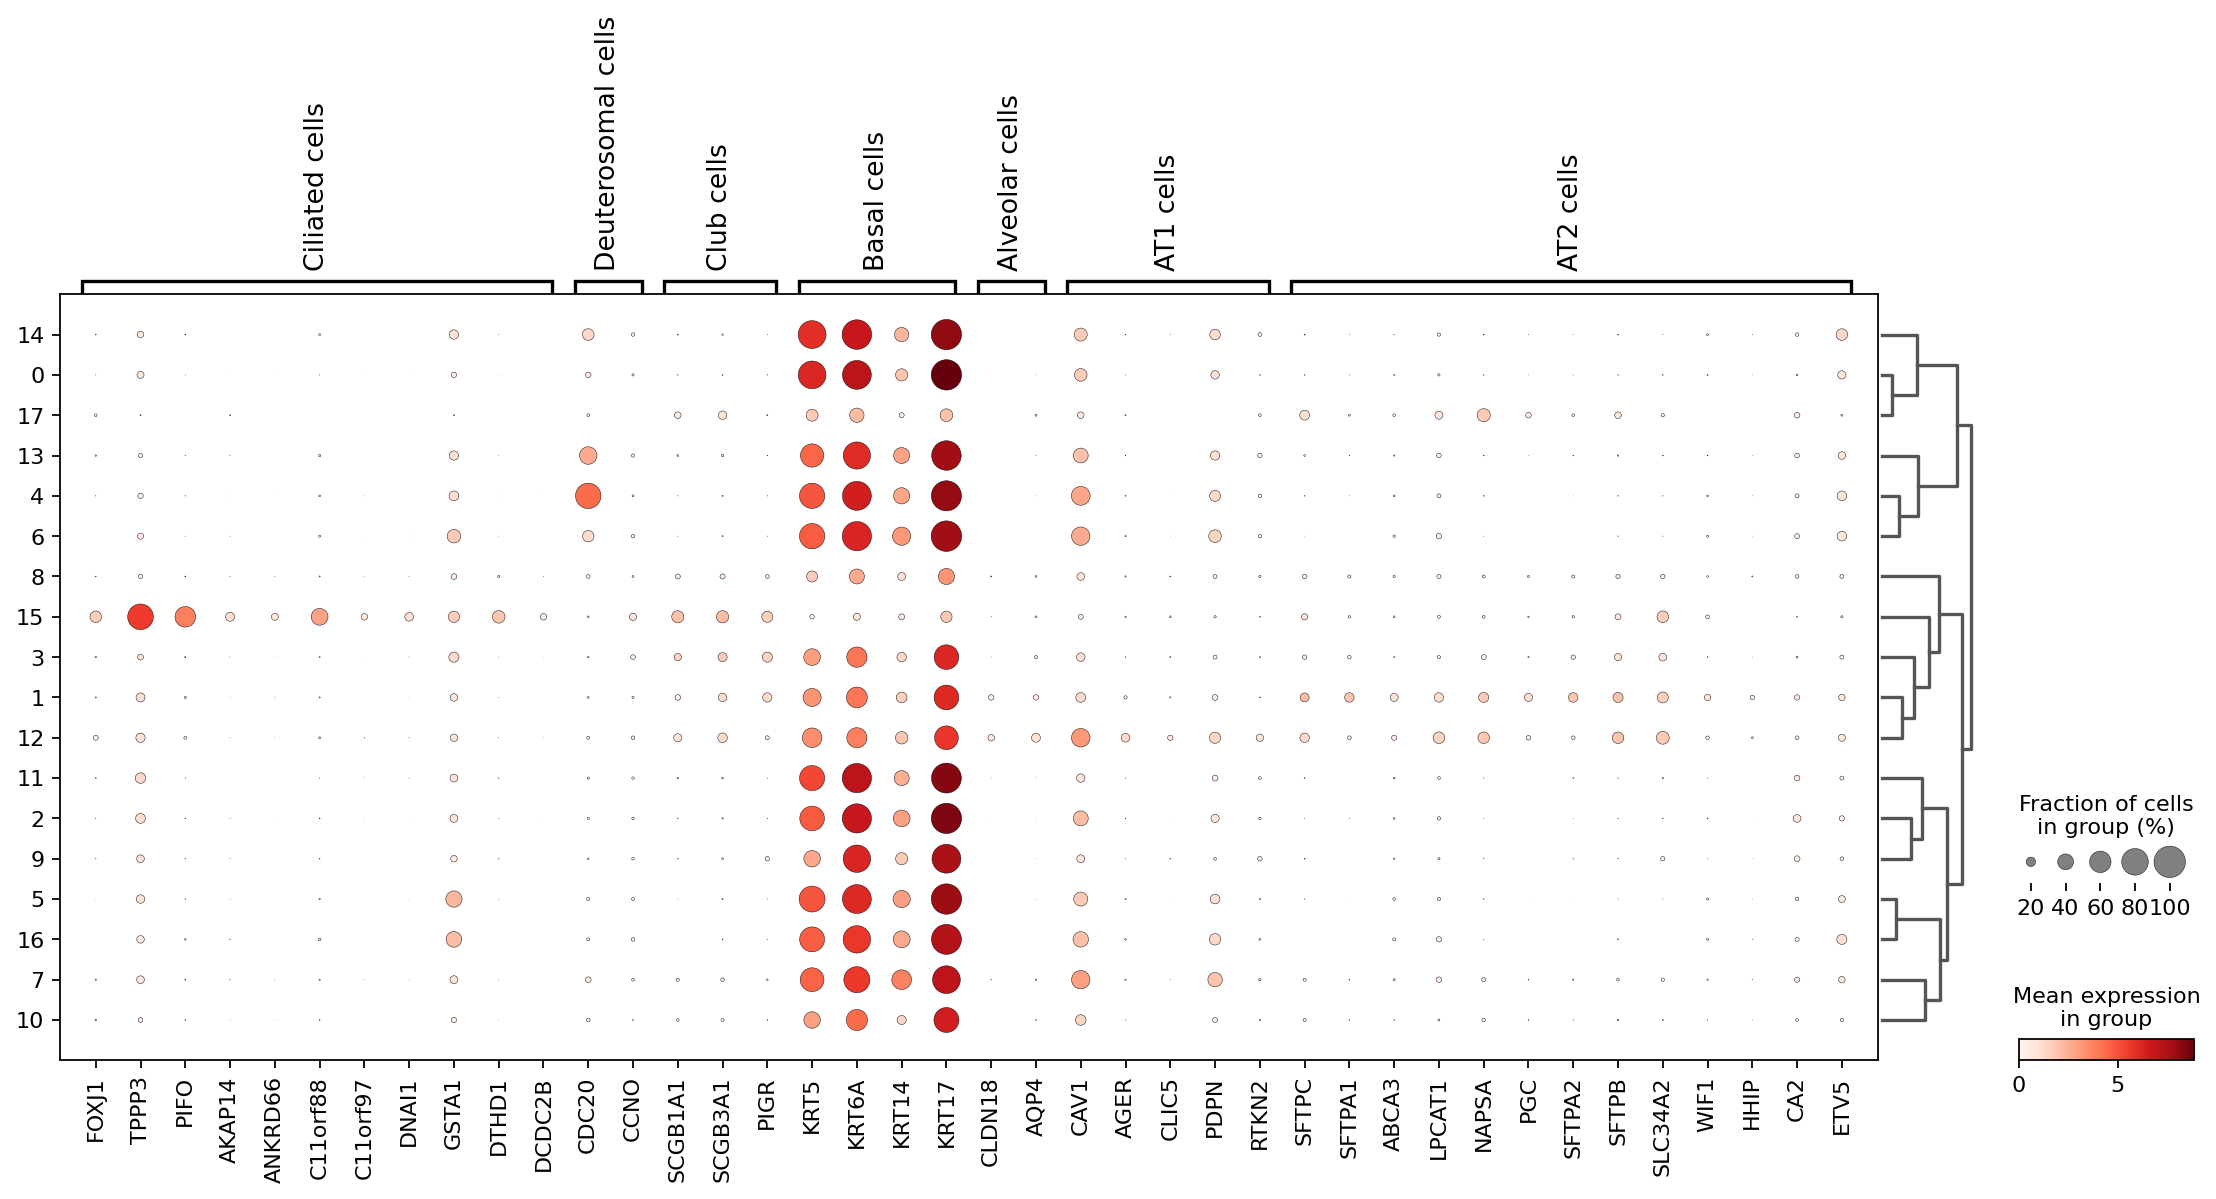

In [17]:
markerDict = {
#'Epithelial cells':['CAPS','SNTN',"EPCAM","KRT18","MUC1"],#####################
'Ciliated cells':['FOXJ1','TPPP3','PIFO',"AKAP14","ANKRD66","C11orf88","C11orf97","DNAI1",'GSTA1','DTHD1','DCDC2B'],
"Deuterosomal cells":['CDC20','CCNO'],
'Club cells':['SCGB1A1','SCGB3A1',"PIGR"],
'Basal cells':['KRT5','KRT6A','KRT14',"KRT17"],
'Alveolar cells':['CLDN18','AQP4'],##
'AT1 cells':['CAV1','AGER',"CLIC5","PDPN",'RTKN2'],
'AT2 cells':['SFTPC','SFTPA1','ABCA3',"LPCAT1","NAPSA","PGC","SFTPA2","SFTPB","SLC34A2",'WIF1','HHIP','CA2','ETV5'],
#"Secretory cells":['SCGB3A2','MUC5AC','TSPAN8','CYP2F1','CEACAM5','VSIG2','FUT6'],
#"Submucosal secretory cells":['MUC5B','TFF3','TFF1','PIP','S100A1','ODAM','CLU','PROM1','RARRES1','CCL28','ALDH1A3','PI3','MIA','KRT23','KRT7','SCGB3A1','RARRES1','ZNHIT6','KRT7','WNT5B','PTK2B','MMP2','COL14A1','NUAK1','G0S2'],
}
sc.pl.dotplot(em, markerDict, groupby='leiden_1', dendrogram=True)

/data/hour/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


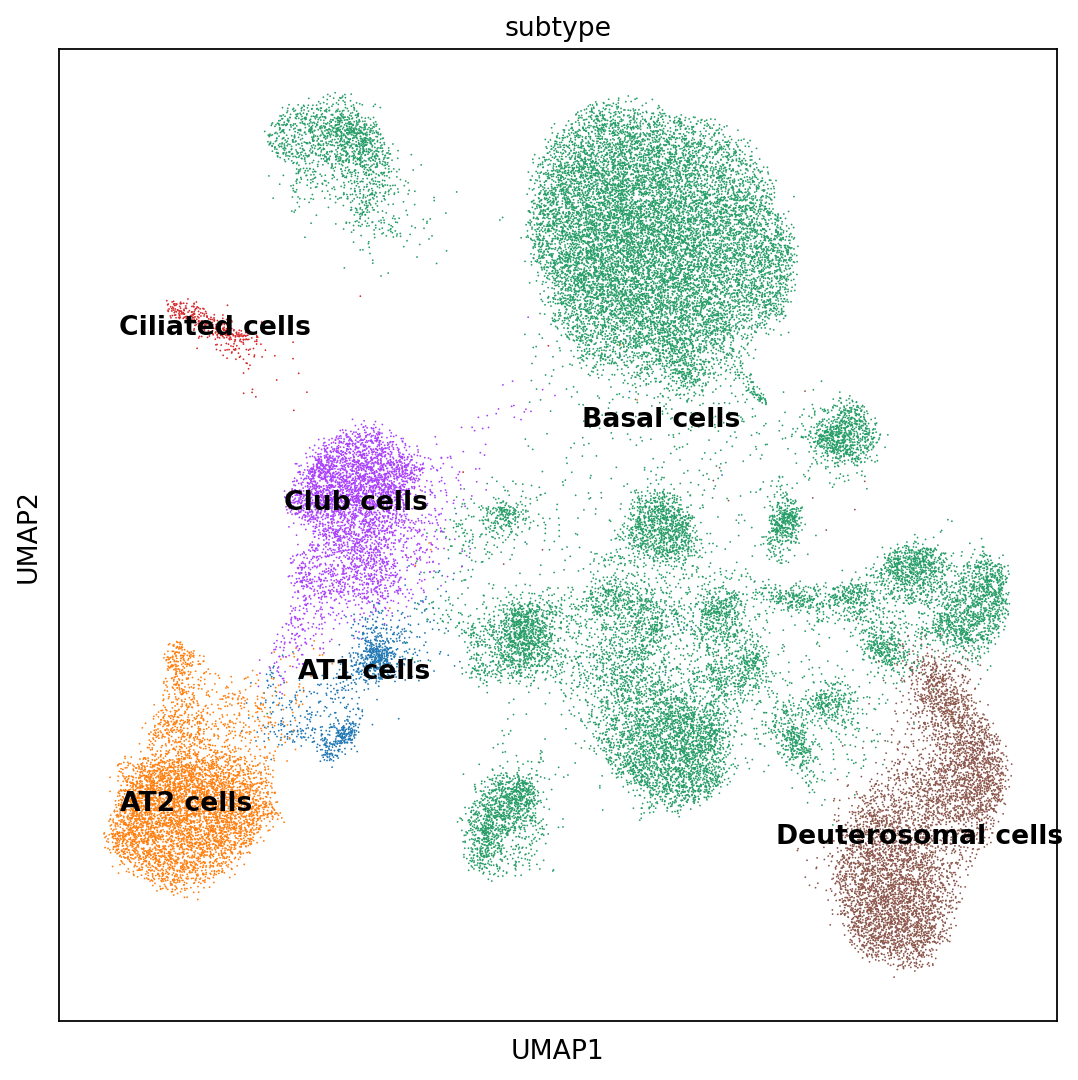

In [22]:
annDict = {
    '0':'Basal cells',
    '1':'AT2 cells',
    '2':'Basal cells',
    '3':'Club cells',
    '4':'Deuterosomal cells',
    '5':'Basal cells',
    '6':'Deuterosomal cells',
    '7':'Basal cells',
    '8':'Basal cells',
    '9':'Basal cells',
    '10':'Basal cells',
    '11':'Basal cells',
    '12':'AT1 cells',
    '13':'Basal cells',
    '14':'Basal cells',
    '15':'Ciliated cells',
    '16':'Basal cells',
    '17':'Basal cells',
    '18':'Basal cells',
}
em.obs['subtype'] = [annDict[i] for i in em.obs['leiden_1']]
sc.pl.umap(em,color=['subtype'],legend_loc='on data',palette=sc.pl.palettes.vega_20_scanpy, save='-Epithelial cells')

In [21]:
em.write('K135_lusc_Epi.h5ad')

In [23]:
em.obs.to_csv('K135_lusc_Epi_obs.csv', index=True, header=True)

# proportion analysis

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
all_obs = pd.read_csv('K135_lusc_all_obs.csv', index_col=0)
all_obs

Tissue Disease    Stage CellName  \
2018jz11_AAACCTGAGGGATCTG-1    Tumor    LUSC        I      CD4   
2018jz11_AAACCTGCACATTCGA-1    Tumor    LUSC        I      CD8   
2018jz11_AAACCTGGTCAGGACA-1    Tumor    LUSC        I       NE   
2018jz11_AAACCTGTCAAAGACA-1    Tumor    LUSC        I        B   
2018jz11_AAACGGGCATACTCTT-1    Tumor    LUSC        I        B   
...                              ...     ...      ...      ...   
P41_TATAAGTGTCTT-59          unknown    LUSC  unknown  unknown   
P41_ATGATCACGAGT-59          unknown    LUSC  unknown  unknown   
P41_CTGACGGTGAAA-59          unknown    LUSC  unknown  unknown   
P41_TTAACTATTCAC-59          unknown    LUSC  unknown  unknown   
P41_TTACGCTTACCT-59          unknown    LUSC  unknown  unknown   

                             n_genes_by_counts  total_counts  total_counts_mt  \
2018jz11_AAACCTGAGGGATCTG-1               1040        3446.0             68.0   
2018jz11_AAACCTGCACATTCGA-1                922        1937.0             52.0   
2018jz11_AAACCTGGTCAGGACA-1               1534        4462.0            613.0   
2018jz11_AAACCTGTCAAAGACA-1               1020        3251.0            138.0   
2018jz11_AAACGGGCATACTCTT-1                707        1739.0             34.0   
...                                        ...           ...              ...   
P41_TATAAGTGTCTT-59                        570         979.0            238.0   
P41_ATGATCACGAGT-59                        534         966.0            140.0   
P41_CTGACGGTGAAA-59                        503         959.0             46.0   
P41_TTAACTATTCAC-59                        500         914.0            234.0   
P41_TTACGCTTACCT-59                        605         974.0             79.0   

                             pct_counts_mt   source    sample patient  \
2018jz11_AAACCTGAGGGATCTG-1       1.973302   wchscu  2018jz11    PS02   
2018jz11_AAACCTGCACATTCGA-1       2.684564   wchscu  2018jz11    PS02   
2018jz11_AAACCTGGTCAGGACA-1      13.738234   wchscu  2018jz11    PS02   
2018jz11_AAACCTGTCAAAGACA-1       4.244848   wchscu  2018jz11    PS02   
2018jz11_AAACGGGCATACTCTT-1       1.955147   wchscu  2018jz11    PS02   
...                                    ...      ...       ...     ...   
P41_TATAAGTGTCTT-59              24.310520  shsfkyy       P41     P41   
P41_ATGATCACGAGT-59              14.492753  shsfkyy       P41     P41   
P41_CTGACGGTGAAA-59               4.796663  shsfkyy       P41     P41   
P41_TTAACTATTCAC-59              25.601751  shsfkyy       P41     P41   
P41_TTACGCTTACCT-59               8.110883  shsfkyy       P41     P41   

                             leiden_0.8  leiden_1         cell type  \
2018jz11_AAACCTGAGGGATCTG-1           3         4           T cells   
2018jz11_AAACCTGCACATTCGA-1           3         4           T cells   
2018jz11_AAACCTGGTCAGGACA-1           0         2   Malignant cells   
2018jz11_AAACCTGTCAAAGACA-1          12        13           B cells   
2018jz11_AAACGGGCATACTCTT-1          12        13           B cells   
...                                 ...       ...               ...   
P41_TATAAGTGTCTT-59                  14        15  Epithelial cells   
P41_ATGATCACGAGT-59                   9        10       Fibroblasts   
P41_CTGACGGTGAAA-59                   8         9     Myeloid cells   
P41_TTAACTATTCAC-59                   9        10       Fibroblasts   
P41_TTACGCTTACCT-59                   0         1  Epithelial cells   

                             cnv_leiden  cnv_score cnv_status stage_group  \
2018jz11_AAACCTGAGGGATCTG-1           2   0.005820     normal           I   
2018jz11_AAACCTGCACATTCGA-1           2   0.005820     normal           I   
2018jz11_AAACCTGGTCAGGACA-1          13   0.012374      tumor           I   
2018jz11_AAACCTGTCAAAGACA-1          18   0.003416     normal           I   
2018jz11_AAACGGGCATACTCTT-1          15   0.004665     normal           I   
...                                 ...        ...        ...         ..

In [5]:
ctList = list(set(em.obs['subtype']))
spList = sorted(list(set(em.obs['stage_sample'])))
spList

['III&IV_2018jz16',
 'III&IV_2018jz27',
 'III&IV_2018jz37',
 'III&IV_2018jz38',
 'III&IV_P1',
 'III&IV_P10',
 'III&IV_P14',
 'III&IV_P15',
 'III&IV_P17',
 'III&IV_P18',
 'III&IV_P19',
 'III&IV_P22',
 'III&IV_P23',
 'III&IV_P25',
 'III&IV_P26',
 'III&IV_P27',
 'III&IV_P3',
 'III&IV_P30',
 'III&IV_P31',
 'III&IV_P36',
 'III&IV_P37',
 'III&IV_P4',
 'III&IV_P40',
 'III&IV_P41',
 'III&IV_P6',
 'III&IV_P7',
 'II_2018jz4',
 'II_AK2831',
 'II_AK2833',
 'II_AK2834',
 'II_AK3272',
 'II_AK3273',
 'II_AK3274',
 'II_AK4295',
 'II_AK4296',
 'II_AK4297',
 'II_AK4298',
 'II_AK576',
 'II_BT1A',
 'II_BT1B',
 'II_BT1C',
 'I_2018jz11',
 'I_2018jz12',
 'I_2018jz46',
 'I_AK658',
 'I_AK659',
 'I_AK660',
 'I_AK661',
 'I_BT1375',
 'I_BT1376',
 'I_BT1377',
 'I_BT2A',
 'I_BT2B',
 'Norm_2018jz14',
 'Norm_2018jz15',
 'Norm_2018jz36',
 'Norm_2018jz39',
 'Norm_2018jz47',
 'Norm_2018jz5',
 'Norm_AK3714',
 'Norm_AK3715',
 'Norm_AK3716',
 'Norm_AK650',
 'Norm_AK651',
 'Norm_AK652',
 'Norm_AK653',
 'Norm_AK831',
 'Norm_

In [6]:
sizes = all_obs.groupby(['subtype', 'stage_sample']).size()
props = sizes.groupby(level=1).apply(lambda x: 100 * x / x.sum()).reset_index() 
props = props.pivot(columns='stage_sample', index='subtype').T
props.index = props.index.droplevel(0)
print(props.index)
props.fillna(0, inplace=True)
props = props.loc[spList,reversed(ctList)]
props

Index(['III&IV_2018jz16', 'III&IV_2018jz27', 'III&IV_2018jz37',
       'III&IV_2018jz38', 'III&IV_P1', 'III&IV_P10', 'III&IV_P14',
       'III&IV_P15', 'III&IV_P17', 'III&IV_P18', 'III&IV_P19', 'III&IV_P22',
       'III&IV_P23', 'III&IV_P25', 'III&IV_P26', 'III&IV_P27', 'III&IV_P3',
       'III&IV_P30', 'III&IV_P31', 'III&IV_P36', 'III&IV_P37', 'III&IV_P4',
       'III&IV_P40', 'III&IV_P41', 'III&IV_P6', 'III&IV_P7', 'II_2018jz4',
       'II_AK2831', 'II_AK2833', 'II_AK2834', 'II_AK3272', 'II_AK3273',
       'II_AK3274', 'II_AK4295', 'II_AK4296', 'II_AK4297', 'II_AK4298',
       'II_AK576', 'II_BT1A', 'II_BT1B', 'II_BT1C', 'I_2018jz11', 'I_2018jz12',
       'I_2018jz46', 'I_AK658', 'I_AK659', 'I_AK660', 'I_AK661', 'I_BT1375',
       'I_BT1376', 'I_BT1377', 'I_BT2A', 'I_BT2B', 'Norm_2018jz14',
       'Norm_2018jz15', 'Norm_2018jz36', 'Norm_2018jz39', 'Norm_2018jz47',
       'Norm_2018jz5', 'Norm_AK3714', 'Norm_AK3715', 'Norm_AK3716',
       'Norm_AK650', 'Norm_AK651', 'Norm_AK652', 'Nor

/tmp/ipykernel_155395/1568215440.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  props = sizes.groupby(level=1).apply(lambda x: 100 * x / x.sum()).reset_index()


subtype          Deuterosomal cells  AT2 cells  AT1 cells  Ciliated cells  \
stage_sample                                                                
III&IV_2018jz16            0.000000   0.147783   0.049261        0.000000   
III&IV_2018jz27            0.000000   0.302480   0.181488        0.000000   
III&IV_2018jz37            3.778135   8.842444   0.884244        0.241158   
III&IV_2018jz38            0.122850   0.614251   0.941851        0.081900   
III&IV_P1                 13.334587   3.799135   0.564228        0.056423   
...                             ...        ...        ...             ...   
Norm_AK832                 0.000000   0.347021   0.115674        0.057837   
Norm_AK833                 0.000000   0.386445   0.118906        0.059453   
Norm_AK834                 0.000000   0.378347   0.116414        0.058207   
Norm_BT1247                0.000000  11.469534   8.243728        0.000000   
Norm_BT1378                0.000000   1.561890   2.186646        0.195236   

subtype          Club cells  Basal cells  
stage_sample                              
III&IV_2018jz16    0.147783     1.379310  
III&IV_2018jz27    0.544465     1.149425  
III&IV_2018jz37    3.376206    20.284030  
III&IV_2018jz38    0.737101     8.149058  
III&IV_P1          2.557833    27.214595  
...                     ...          ...  
Norm_AK832         0.289184     1.706189  
Norm_AK833         0.297265     1.605232  
Norm_AK834         0.291036     1.571595  
Norm_BT1247        0.358423     0.716846  
Norm_BT1378        0.273331     1.171417  

[72 rows x 6 columns]

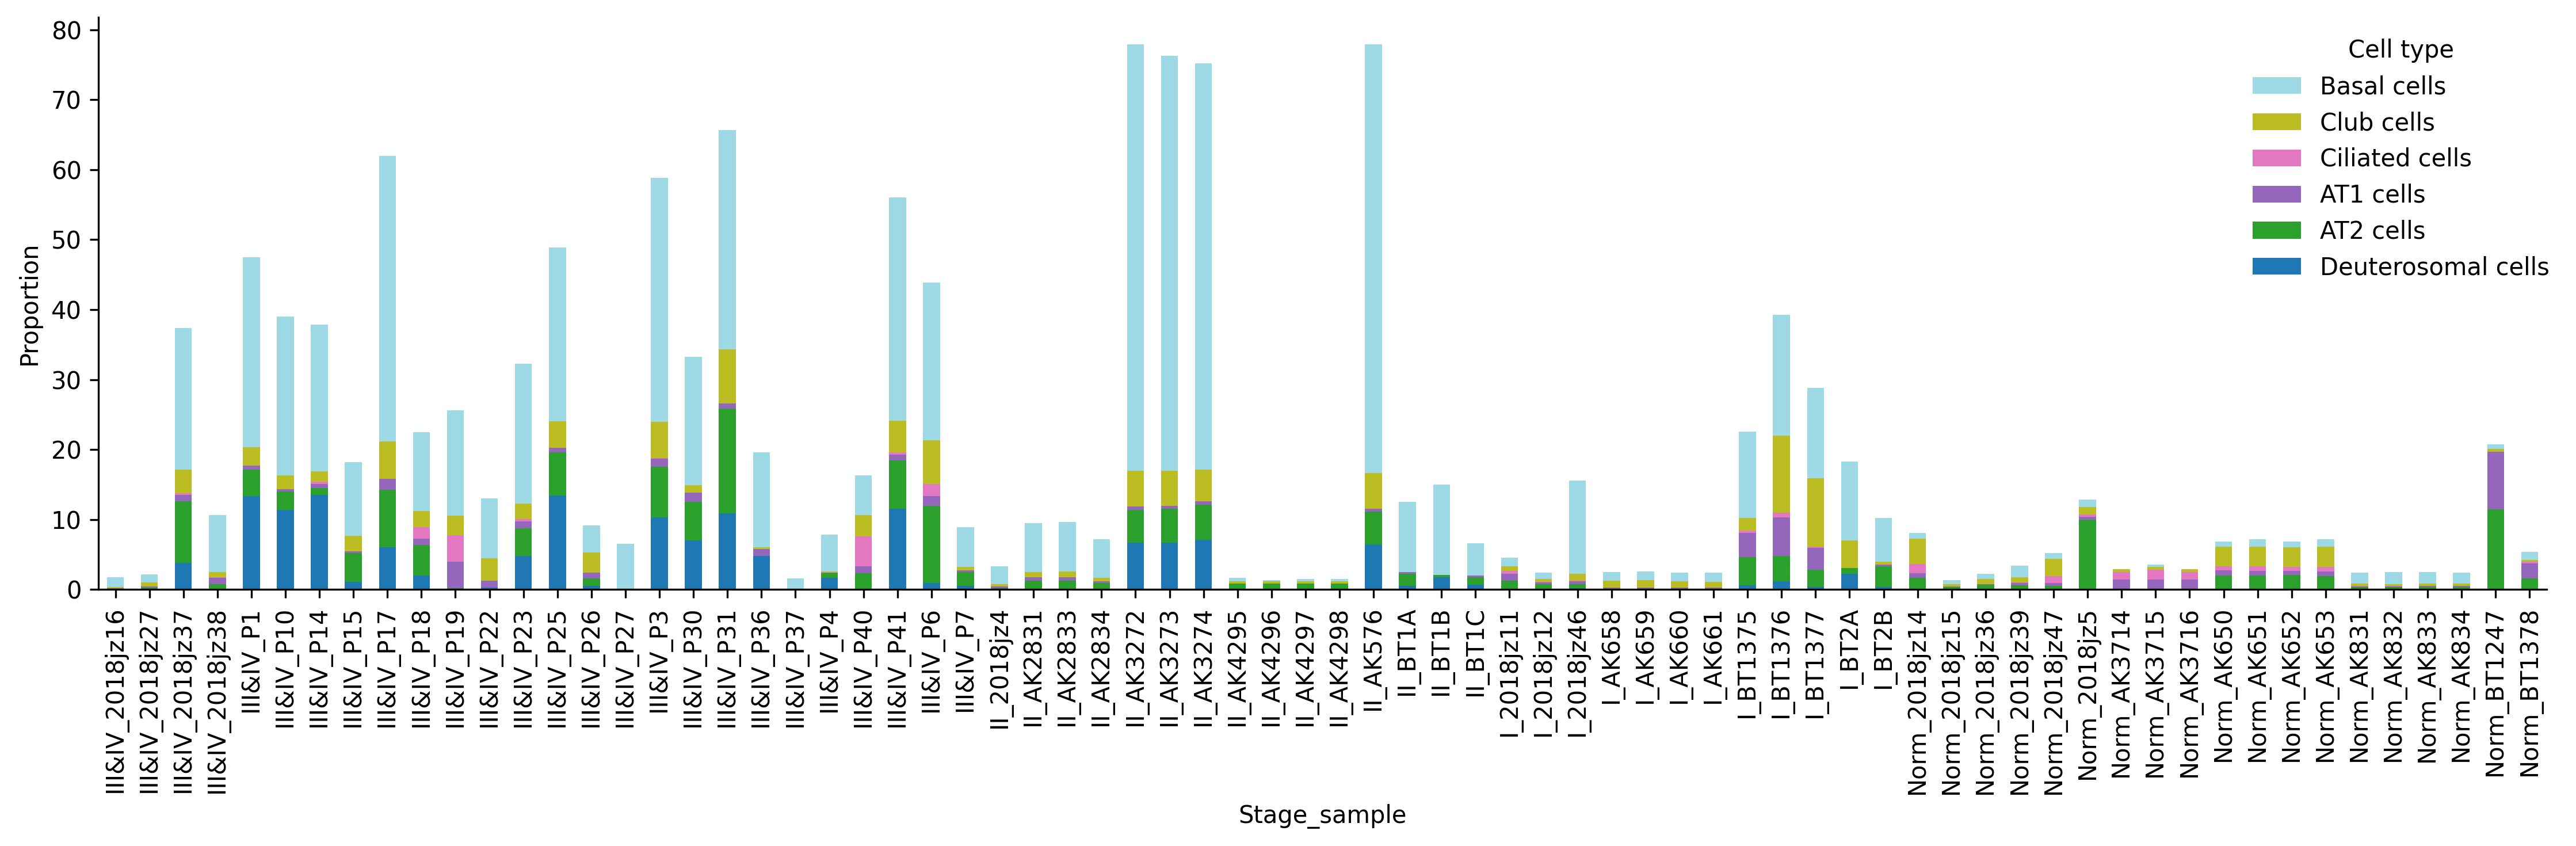

In [7]:
fig, ax = plt.subplots(dpi=300, figsize=(15, 5))
props.plot(kind="bar", stacked=True, ax=ax, legend=None, colormap='tab20')
# Matplotlib idiom to reverse legend entries 
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels),bbox_to_anchor=(1.01, 1), frameon=False, title="Cell type")
sns.despine(fig, ax)
ax.tick_params(axis="x", rotation=90)
ax.set_xlabel(props.index.name.capitalize())
ax.set_ylabel("Proportion")
fig.patch.set_facecolor("white")
plt.grid(False)
#sc.settings.set_figure_params(fontsize=10, figsize=(5, 25))
fig.tight_layout()
fig.savefig('figures/fraction-Epithelial cells.pdf')

In [40]:
from scipy.stats import f_oneway

In [41]:
I_list = set([em.obs.loc[i,'stage_sample'] for i in em.obs.index if em.obs.loc[i,'stage_group']=='I'])
II_list = set([em.obs.loc[i,'stage_sample'] for i in em.obs.index if em.obs.loc[i,'stage_group']=='II'])
IIIIV_list = set([em.obs.loc[i,'stage_sample'] for i in em.obs.index if em.obs.loc[i,'stage_group']=='III&IV'])
Norm_list = set([em.obs.loc[i,'stage_sample'] for i in em.obs.index if em.obs.loc[i,'stage_group']=='Norm'])

In [48]:
for ct in ctList:
    print(ct,'-> pvalue:')
    print(f_oneway(props.loc[I_list,ct],
             props.loc[II_list,ct],
             props.loc[IIIIV_list,ct],
             props.loc[Norm_list,ct]).pvalue)

Ciliated cells -> pvalue:
0.1371636689635524
Deuterosomal cells -> pvalue:
0.00012946650405286716
Basal cells -> pvalue:
0.00046575698798715336
Club cells -> pvalue:
0.16523239152199076
AT2 cells -> pvalue:
0.09167646407509568
AT1 cells -> pvalue:
0.18201963234530288


/tmp/ipykernel_328109/608974009.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  print(f_oneway(props.loc[I_list,ct],
/tmp/ipykernel_328109/608974009.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  props.loc[II_list,ct],
/tmp/ipykernel_328109/608974009.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  props.loc[IIIIV_list,ct],
/tmp/ipykernel_328109/608974009.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  props.loc[Norm_list,ct]).pvalue)
/tmp/ipykernel_328109/608974009.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  print(f_oneway(props.loc[I_list,ct],
/tmp/ipykernel_328109/608974009.py:4: FutureWarning: Passing a set as an indexe

In [38]:
props['stage'] = [i.split('_')[0] for i in props.index]
props

subtype          AT1 cells  AT2 cells  Club cells  Basal cells  \
stage_sample                                                     
III&IV_2018jz16   0.049261   0.147783    0.147783     1.379310   
III&IV_2018jz27   0.181488   0.302480    0.544465     1.149425   
III&IV_2018jz37   0.884244   8.842444    3.376206    20.284030   
III&IV_2018jz38   0.941851   0.614251    0.737101     8.149058   
III&IV_P1         0.564228   3.799135    2.557833    27.214595   
...                    ...        ...         ...          ...   
Norm_AK832        0.115674   0.347021    0.289184     1.706189   
Norm_AK833        0.118906   0.386445    0.297265     1.605232   
Norm_AK834        0.116414   0.378347    0.291036     1.571595   
Norm_BT1247       8.243728  11.469534    0.358423     0.716846   
Norm_BT1378       2.186646   1.561890    0.273331     1.171417   

subtype          Deuterosomal cells  Ciliated cells   stage  
stage_sample                                                 
III&IV_2018jz16            0.000000        0.000000  III&IV  
III&IV_2018jz27            0.000000        0.000000  III&IV  
III&IV_2018jz37            3.778135        0.241158  III&IV  
III&IV_2018jz38            0.122850        0.081900  III&IV  
III&IV_P1                 13.334587        0.056423  III&IV  
...                             ...             ...     ...  
Norm_AK832                 0.000000        0.057837    Norm  
Norm_AK833                 0.000000        0.059453    Norm  
Norm_AK834                 0.000000        0.058207    Norm  
Norm_BT1247                0.000000        0.000000    Norm  
Norm_BT1378                0.000000        0.195236    Norm  

[72 rows x 7 columns]

In [39]:
props.to_csv('proportion/K135_proportion_Epi.csv', index=True, header=True)#violin plot by R

In [6]:
sc.tl.rank_genes_groups(em, "subtype",method="t-test")

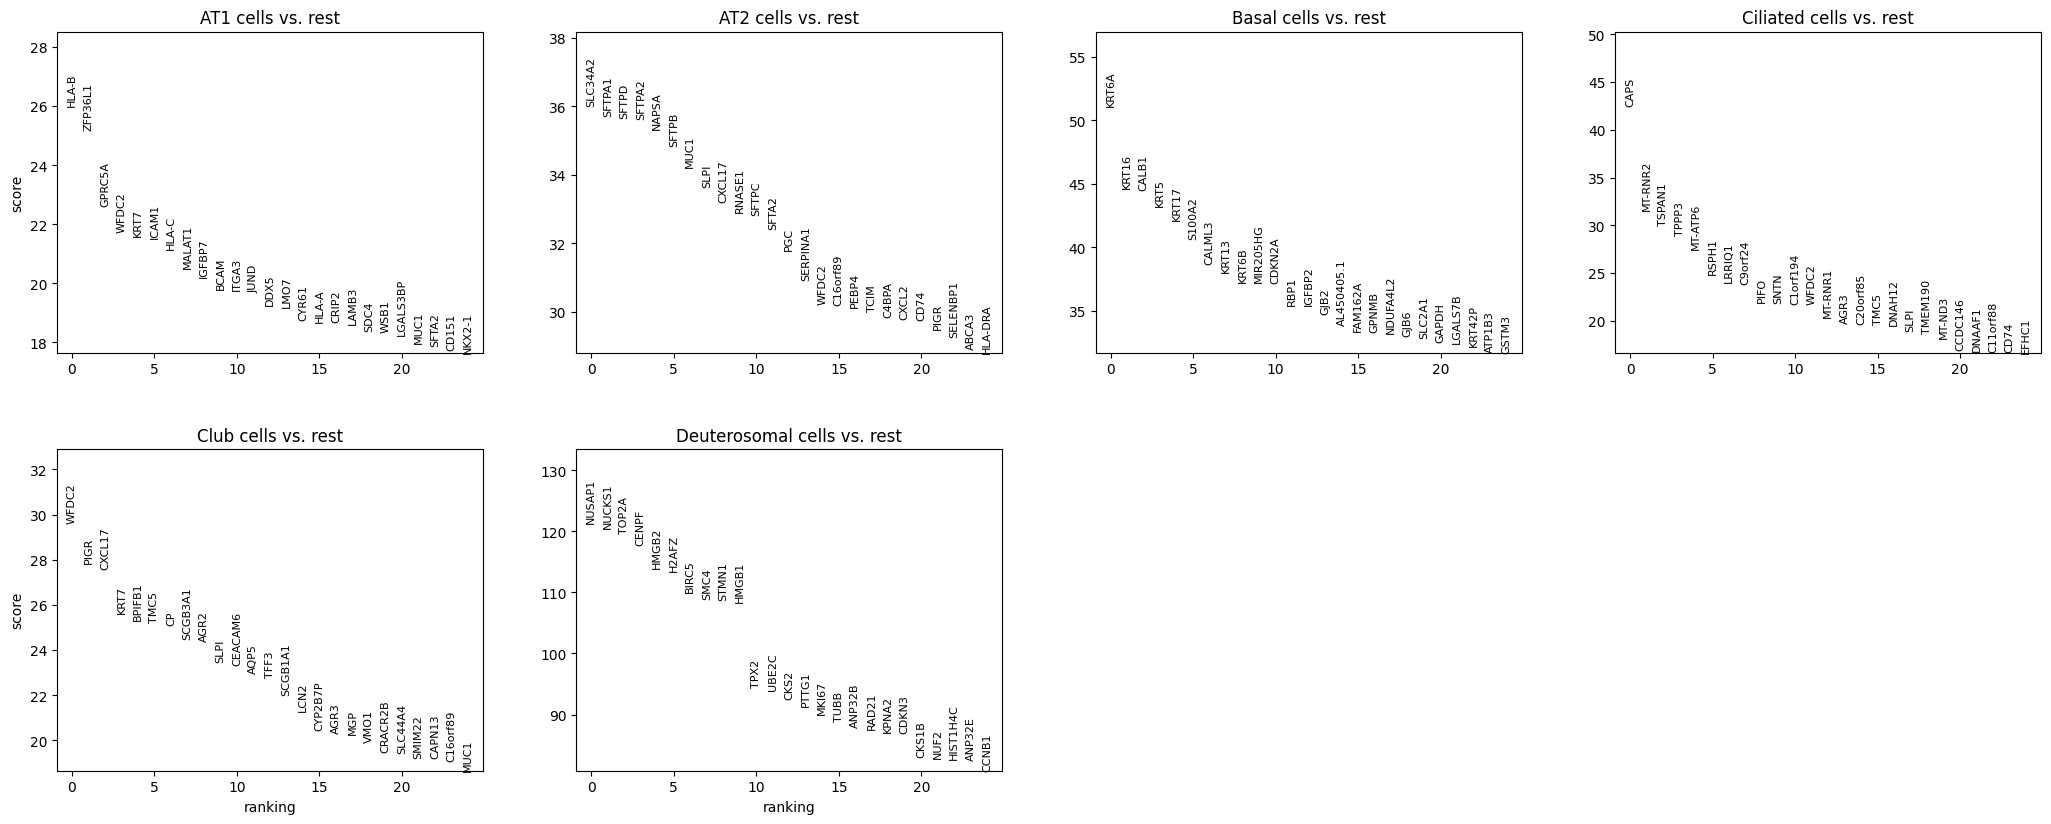

In [7]:
sc.pl.rank_genes_groups(em,n_genes=25,sharey=False)

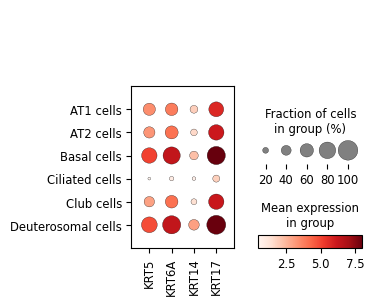

In [69]:
import os
#单个细胞类型绘制
index = 4
df = pd.DataFrame(em.uns["rank_genes_groups"]["names"]).head(400)
#df.to_csv(os.path.join('marker','Epithelial.csv'), index=True, header=True)

#替换线粒体基因
df2 = pd.DataFrame(em.uns["rank_genes_groups"]["names"]).head(400)
new_markers_tmp = df2.iloc[:,index]
new_markers = [i for i in new_markers_tmp if not i.startswith("MT-")]
marker_genes = new_markers[200:400]
marker_genes =['KRT5','KRT6A','KRT14',"KRT17"]
sc.pl.dotplot(em, marker_genes, groupby="subtype")

In [53]:
['AGER','RTKN2','SFTPA1','ABCA3',"SFTPA2",'PIFO',"C11orf88",'DTHD1','CDC20','TOP2A','CENPF']

['AGER',
 'RTKN2',
 'SFTPA1',
 'ABCA3',
 'SFTPA2',
 'PIFO',
 'C11orf88',
 'DTHD1',
 'TMC5',
 'TFF3',
 'AGR3',
 'CDC20',
 'TOP2A',
 'CENPF']

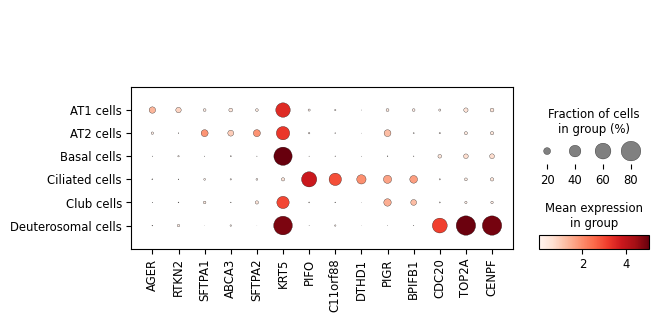

In [71]:
import os
df = pd.DataFrame(em.uns["rank_genes_groups"]["names"]).head(100)
marker_genes = ['AGER','RTKN2','SFTPA1','ABCA3',"SFTPA2",'KRT5','PIFO',"C11orf88",'DTHD1','PIGR','BPIFB1','CDC20','TOP2A','CENPF']
sc.pl.dotplot(em, marker_genes, groupby="subtype",save='dotplot_epithelial_markers.pdf')

In [ ]:
markerDict = {
#'Epithelial cells':['CAPS','SNTN',"EPCAM","KRT18","MUC1"],#####################
'Ciliated cells':['FOXJ1','TPPP3','PIFO',"AKAP14","ANKRD66","C11orf88","C11orf97","DNAI1",'GSTA1','DTHD1','DCDC2B'],
"Deuterosomal cells":['CDC20','CCNO'],
'Club cells':['SCGB1A1','SCGB3A1',"PIGR"],
'Basal cells':['KRT5','KRT6A','KRT14',"KRT17"],
'Alveolar cells':['CLDN18','AQP4'],##
'AT1 cells':['CAV1','AGER',"CLIC5","PDPN",'RTKN2'],
'AT2 cells':['SFTPC','SFTPA1','ABCA3',"LPCAT1","NAPSA","PGC","SFTPA2","SFTPB","SLC34A2",'WIF1','HHIP','CA2','ETV5'],
#"Secretory cells":['SCGB3A2','MUC5AC','TSPAN8','CYP2F1','CEACAM5','VSIG2','FUT6'],
#"Submucosal secretory cells":['MUC5B','TFF3','TFF1','PIP','S100A1','ODAM','CLU','PROM1','RARRES1','CCL28','ALDH1A3','PI3','MIA','KRT23','KRT7','SCGB3A1','RARRES1','ZNHIT6','KRT7','WNT5B','PTK2B','MMP2','COL14A1','NUAK1','G0S2'],
}